In [208]:
import lib
import qutip as qt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time

In [195]:
repr(h.data).split('nnz')[-1][1:-1]

'11264'

In [200]:
ns = [i for i in range(2, 20)]
nnzs = []
for n in ns:
    h = lib.TFIM_hamiltonian(n, 1, 1)
    nnzs.append(int(repr(h.data).split('nnz')[-1][1:-1]))

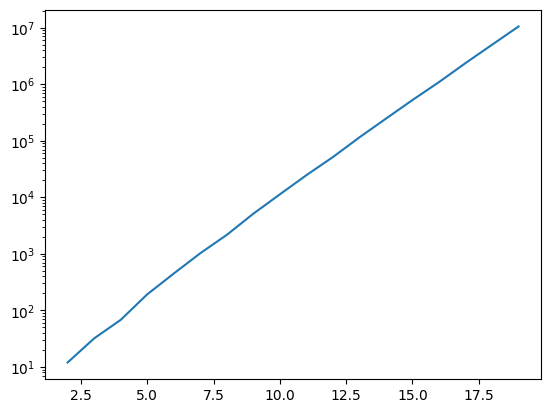

In [203]:
plt.plot(ns, nnzs)
plt.yscale('log')
plt.show()

In [473]:
N = 3
J = 1
Gamma = 0.1

In [474]:
h = lib.TFIM_hamiltonian(N, J, Gamma)

In [475]:
h.eigenstates()

(array([-3.0078784 , -3.00713075,  0.8078784 ,  0.9       ,  0.9       ,
         1.1       ,  1.1       ,  1.20713075]),
 array([Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.70637642]
         [-0.01855039]
         [-0.01855039]
         [-0.01855039]
         [-0.01855039]
         [-0.01855039]
         [-0.01855039]
         [-0.70637642]]                                                                   ,
        Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.7065083 ]
         [ 0.01679311]
         [ 0.01679311]
         [-0.01679311]
         [ 0.01679311]
         [-0.01679311]
         [-0.01679311]
         [-0.7065083 ]]                                                                   ,
        Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.03213022]
         [-0.407

In [476]:
h.eigenstates()[0][0]

np.float64(-3.007878402833895)

In [477]:
h.eigenstates()[1][0]

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[-0.70637642]
 [-0.01855039]
 [-0.01855039]
 [-0.01855039]
 [-0.01855039]
 [-0.01855039]
 [-0.01855039]
 [-0.70637642]]

In [478]:
c = 1e-12
def reim(nn_output):
    return nn_output[:, 0] + 1.j * nn_output[:, 1] # Re, Im
def logamp_phase_c(nn_output):
    return (torch.exp(-nn_output[:, 0]) - c) * torch.exp(1.j * nn_output[:, 1]) 
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])

In [479]:
input = lib.generate_input_torch(N)

In [550]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
    nn.Sigmoid()
)

In [553]:
vars = (N, J, Gamma)
loss_fn = lib.TFIM_expectation_from_torch
epochs = []
loss_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 10)
for epoch in range(1000):
    y_pred = model(input)
    loss = loss_fn(y_pred, vars, amp_phase)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        loss_data.append(loss.item())
        epochs.append(epoch)

# find groud state
gs = lib.model_to_ground_state(model, input, amp_phase)

In [554]:
loss_data[-1]

-3.007498264312744

In [555]:
gs

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[-8.87651086e-01+4.58471477e-01j]
 [-2.21675895e-02+1.14489170e-02j]
 [-2.21680272e-02+1.14490557e-02j]
 [-1.77654682e-03+9.45373497e-04j]
 [-2.21738890e-02+1.14534153e-02j]
 [-1.69877312e-03+9.01570078e-04j]
 [-1.71257497e-03+8.86173337e-04j]
 [-4.70830710e-04+2.59304157e-04j]]

In [469]:
h.dims = [2 ** N, 2 ** N]

In [470]:
np.array(h.full())

array([[-2. +0.j, -0.1+0.j, -0.1+0.j,  0. +0.j],
       [-0.1+0.j,  2. +0.j,  0. +0.j, -0.1+0.j],
       [-0.1+0.j,  0. +0.j,  2. +0.j, -0.1+0.j],
       [ 0. +0.j, -0.1+0.j, -0.1+0.j, -2. +0.j]])

In [471]:
gs.dag().full() @ h.full() @ gs.full()

array([[-2.0099752+0.j]])

In [472]:
(h.full() @ gs.full()) / gs.full()

array([[-2.00997514-3.35738121e-09j],
       [-2.00996876+2.58283282e-06j],
       [-2.00996532+2.52999956e-06j],
       [-2.00997515-9.36124030e-09j]])